In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [2]:
city_data = pd.read_csv("city_data.csv").iloc[:, 1:]
shootings = pd.read_csv("PoliceKillingsUS.csv",encoding='latin1')

valid_cities = shootings[['state','city']]


cluster_data = city_data.merge(valid_cities.drop_duplicates(), how="inner", left_on = ['Geographic Area','City'], 
                               right_on = ['state', 'city'])

cluster_data.drop(columns=['Geographic Area','City'], inplace=True)

for col in cluster_data.columns[:-2]:
    cluster_data[col] = np.log(cluster_data[col]+1)
    cluster_data[col] = (cluster_data[col]-cluster_data[col].min())/(cluster_data[col].max()-cluster_data[col].min())

In [3]:
cluster_data.head()

,Median Income,poverty_rate,percent_completed_hs,share_white,share_black,share_native_american,share_asian,share_hispanic,state,city
0,0.280501,0.756518,0.581531,0.859642,0.815463,0.020669,0.167364,0.307469,AL,Abbeville
1,0.449607,0.619637,0.849904,0.991997,0.020742,0.101928,0.128123,0.216440,AL,Arab
2,0.451962,0.749574,0.712675,0.935981,0.665643,0.039539,0.063349,0.341818,AL,Ashville
3,0.358607,0.731347,0.734336,0.883676,0.781659,0.150320,0.141924,0.224365,AL,Bay Minette
4,0.352468,0.771491,0.817107,0.657212,0.937833,0.039539,0.167364,0.332544,AL,Birmingham


In [4]:
data = cluster_data.iloc[:,:-2]

pca=PCA()

pca.fit(data)

PCA()

In [5]:
pca.explained_variance_ratio_

array([0.32421916, 0.28503034, 0.19696838, 0.06979046, 0.06333654,
       0.0332749 , 0.01882134, 0.00855886])

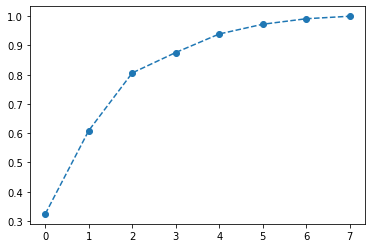

In [6]:
plt.plot(range(8),pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')

In [7]:
pca=PCA(n_components=4)
pca.fit(data)

PCA(n_components=4)

In [8]:
scores_pca = pca.transform(data)

In [9]:
ds = []

for i in range(1,15):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    ds.append(kmeans_pca.inertia_)

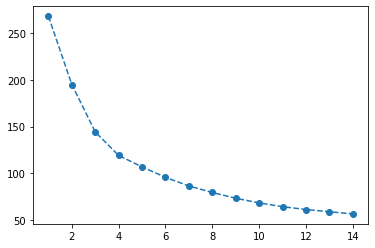

In [10]:
plt.plot(range(1,15), ds, marker='o', linestyle='--')

In [11]:
kmeans_pca = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=3, random_state=42)

In [12]:
di = {0: "A", 1: "B", 2:"C", 3:"D"}
labels = [di[l] for l in kmeans_pca.labels_]
city_clustered = cluster_data.copy()
city_clustered['ClusterLabel'] = labels

ValueError: The palette list has the wrong number of colors.

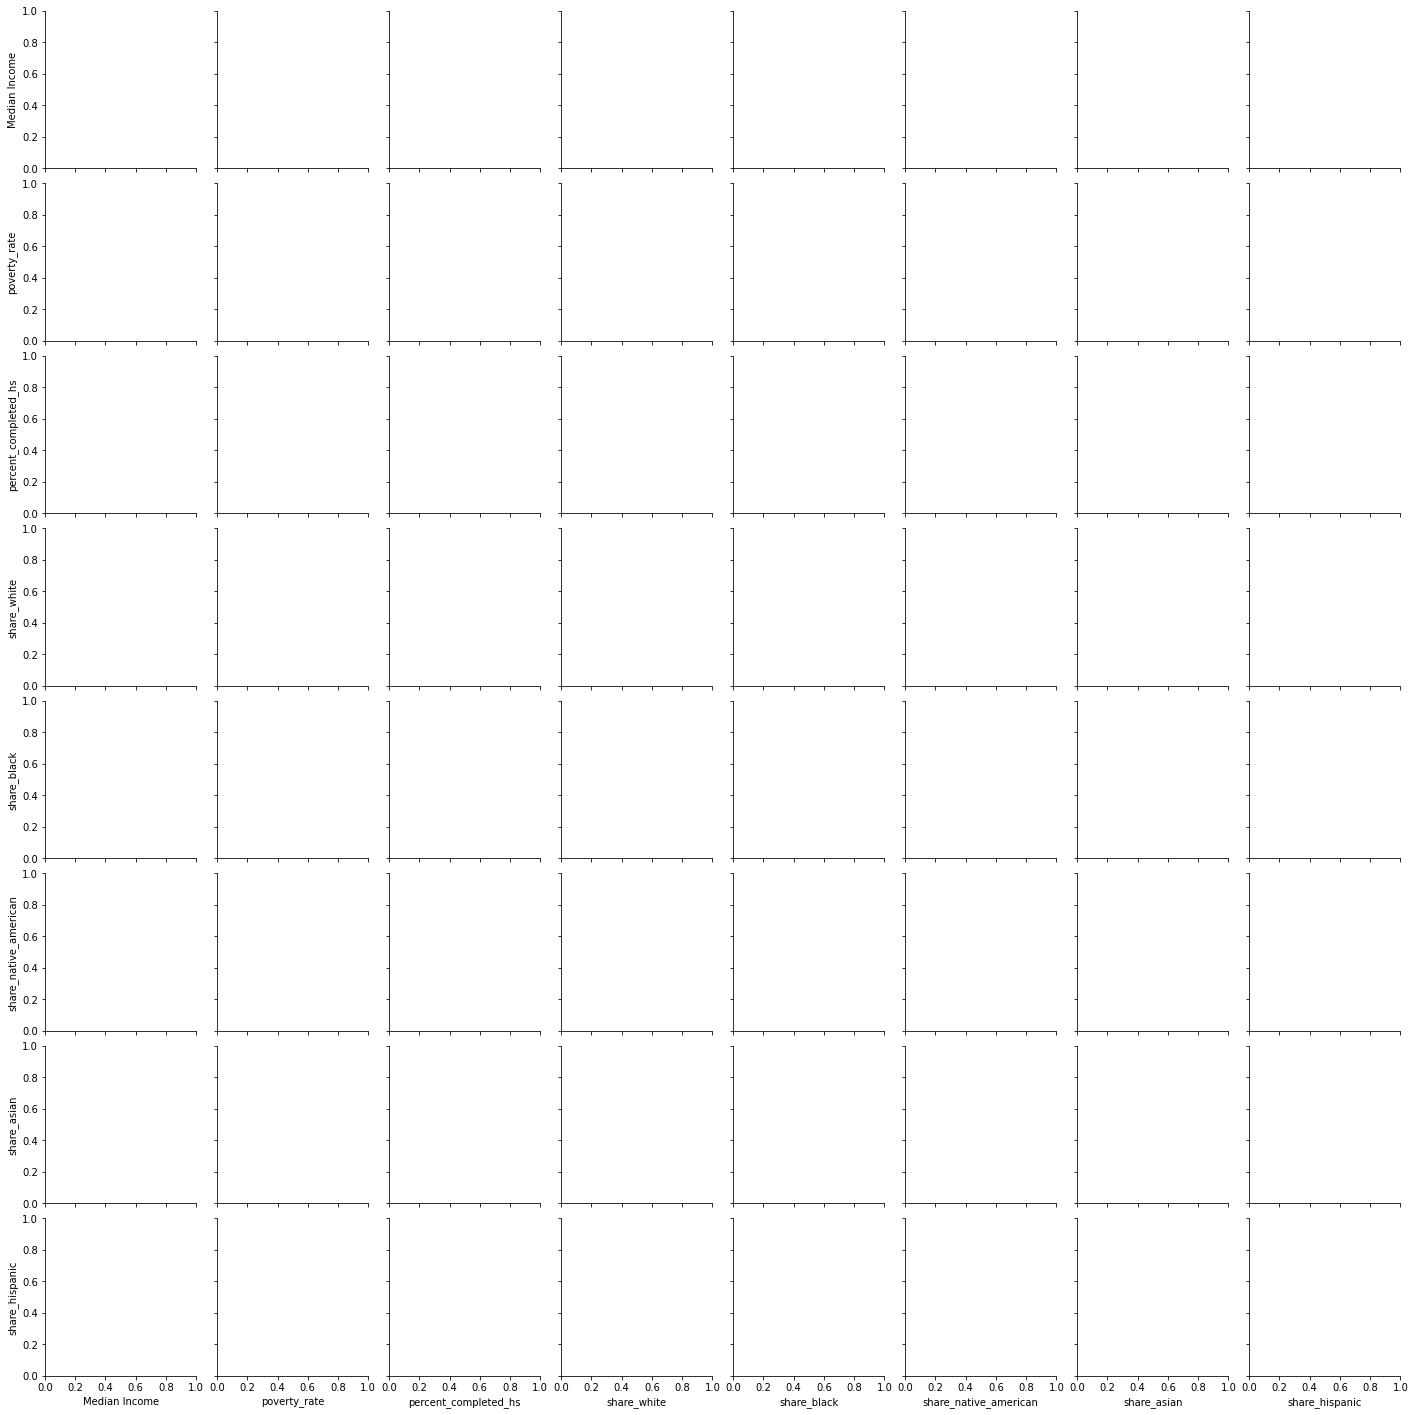

In [13]:
sns.pairplot(data=city_clustered, hue='ClusterLabel', palette=['black','blue','yellow','red'], 
             vars=city_clustered.columns[:-3])
plt.show()

In [14]:
city_clustered.groupby(
    ['ClusterLabel']
).agg(
    {
        'Median Income': ['mean','count'],
        'poverty_rate': ['mean','count'],
        'percent_completed_hs': ['mean','count'],
        'share_white': ['mean','count'],
        'share_black': ['mean','count'],
        'share_native_american': ['mean','count'],
        'share_asian': ['mean','count'],
        'share_hispanic': ['mean','count'],
    }
)

Median Income       poverty_rate       percent_completed_hs  \
                      mean count         mean count                 mean   
ClusterLabel                                                               
A                 0.564276   428     0.592803   428             0.768624   
B                 0.441205   416     0.677715   416             0.789006   
C                 0.490343   427     0.587233   427             0.851094   

                   share_white       share_black       share_native_american  \
             count        mean count        mean count                  mean   
ClusterLabel                                                                   
A              428    0.895422   428    0.373369   428              0.150043   
B              416    0.857095   416    0.720305   416              0.083130   
C              427    0.964960   427    0.186641   427              0.158502   

                   share_asian       share_hispanic        
             count        mean count           mean count  
ClusterLabel                                               
A              428    0.416905   428       0.736932   428  
B              416    0.216157   416       0.424635   416  
C              427    0.161981   427       0.352873   427

In [15]:
shootings['age'] = shootings['age'].astype(float)

In [16]:
arm = {'unarmed': ['unarmed'], 
 'low risk':['toy weapon','stapler', 'beer bottle', 'pen', 'hand torch', 'flashlight'],
 'electrical tool': ['nail gun', 'cordless drill', 'Taser', 'bean-bag gun', 'fireworks'],
 'cold weapon': ['knife', 'shovel', 'hammer', 'hatchet', 'sword', 'machete', 'box cutter', 'metal object', 'screwdriver', 'flagpole', 'crossbow',
      'metal pole', 'metal pipe', 'metal hand tool', 'blunt object', 'metal stick', 'sharp object', 'meat cleaver', 'baseball bat and fireplace poker', 
      'straight edge razor', 'ax', 'brick', 'baseball bat','chain saw', 'garden tool', 'scissors', 'pole', 'pick-axe', 'baton', 'spear', 'pitchfork',
      'rock', 'piece of wood', 'bayonet', 'pipe', 'glass shard','metal rake', 'crowbar', 'oar', 'baseball bat and bottle', 'tire iron', 'pole and knife',
      'chain', "contractor's level"],
 'heavy object': ['vehicle', 'lawn mower blade', 'motorcycle', 'carjack', 'air conditioner'],
 'gun':['gun', 'guns and explosives', 'gun and knife', 'hatchet and gun', 'machete and gun'],
 'undetermined':['undetermined', 'unknown weapon']}

arm_class = shootings.armed.tolist()
for classes in arm:
    arm_class = [classes if x in arm[classes] else x for x in arm_class]
shootings['armed'] = arm_class

In [17]:
shootings.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,04/01/15,shot,low risk,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,04/01/15,shot,electrical tool,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


In [18]:
cluster_results = city_clustered.iloc[:,8:]

tree_data = shootings.merge(cluster_results, how='left', on=['state','city'])

arm_type = pd.get_dummies(tree_data.armed, prefix ='arm')
gender = pd.get_dummies(tree_data.gender, prefix ='gender')
race = pd.get_dummies(tree_data.race, prefix ='race')
mental_illness = pd.get_dummies(tree_data.signs_of_mental_illness, prefix ='mental_illness')
threat_level = pd.get_dummies(tree_data.threat_level, prefix ='threat_level')
flee = pd.get_dummies(tree_data.flee, prefix ='flee')
body_cam = pd.get_dummies(tree_data.body_camera, prefix ='body_cam')

tree_data = pd.concat([tree_data, arm_type, gender, race, mental_illness, threat_level, flee, body_cam], axis=1)

In [19]:
tree_data.columns

Index(['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender',
       'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera', 'ClusterLabel', 'arm_cold weapon',
       'arm_electrical tool', 'arm_gun', 'arm_heavy object', 'arm_low risk',
       'arm_unarmed', 'arm_undetermined', 'gender_F', 'gender_M', 'race_A',
       'race_B', 'race_H', 'race_N', 'race_O', 'race_W',
       'mental_illness_False', 'mental_illness_True', 'threat_level_attack',
       'threat_level_other', 'threat_level_undetermined', 'flee_Car',
       'flee_Foot', 'flee_Not fleeing', 'flee_Other', 'body_cam_False',
       'body_cam_True'],
      dtype='object')

In [20]:
tree_data = tree_data.iloc[:,4:]
tree_data.drop(columns=["armed","gender","race","city","state","signs_of_mental_illness","threat_level","flee",
                      "body_camera"], inplace=True)
tree_data.drop(columns=["arm_undetermined","gender_F","race_W","mental_illness_False","threat_level_other","flee_Other","body_cam_False"], 
              inplace=True)

tree_data.head()

,age,ClusterLabel,arm_cold weapon,arm_electrical tool,arm_gun,arm_heavy object,arm_low risk,arm_unarmed,gender_M,race_A,...,race_H,race_N,race_O,mental_illness_True,threat_level_attack,threat_level_undetermined,flee_Car,flee_Foot,flee_Not fleeing,body_cam_True
0,53.0,C,0,0,1,0,0,0,1,1,...,0,0,0,1,1,0,0,0,1,0
1,47.0,A,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2,23.0,A,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,1,0
3,32.0,A,0,0,0,0,1,0,1,0,...,0,0,0,1,1,0,0,0,1,0
4,39.0,A,0,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0


In [21]:
# drop na 
print(tree_data.shape)
tree_data=tree_data.dropna()
print(tree_data.shape)

(2541, 21)
(2155, 21)


In [22]:
tree_data['ClusterLabel'].value_counts()

A    942
B    716
C    497
Name: ClusterLabel, dtype: int64

In [23]:
#Creating the dependent variable class
factor = pd.factorize(tree_data['ClusterLabel'])
tree_data.ClusterLabel = factor[0]
definitions = factor[1]
print(tree_data.ClusterLabel.head())
print(definitions)
tree_data.head()

0    0
1    1
2    1
3    1
4    1
Name: ClusterLabel, dtype: int64
Index(['C', 'A', 'B'], dtype='object')


,age,ClusterLabel,arm_cold weapon,arm_electrical tool,arm_gun,arm_heavy object,arm_low risk,arm_unarmed,gender_M,race_A,...,race_H,race_N,race_O,mental_illness_True,threat_level_attack,threat_level_undetermined,flee_Car,flee_Foot,flee_Not fleeing,body_cam_True
0,53.0,0,0,0,1,0,0,0,1,1,...,0,0,0,1,1,0,0,0,1,0
1,47.0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2,23.0,1,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,1,0
3,32.0,1,0,0,0,0,1,0,1,0,...,0,0,0,1,1,0,0,0,1,0
4,39.0,1,0,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0


In [24]:
#Splitting the data into independent and dependent variables
X = tree_data.drop(['ClusterLabel'], axis=1)
y = tree_data['ClusterLabel'].values

In [25]:
# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

In [26]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
classifier = RandomForestClassifier(n_estimators = 30, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=30, random_state=42)

In [28]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
#Reverse factorize 
reversefactor = dict(zip(range(4),definitions))
y_test = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Cluster'], colnames=['Predicted Cluster']))

Predicted Cluster   A   B   C
Actual Cluster               
A                  96  63  31
B                  44  68  29
C                  27  27  46


In [29]:
cm = pd.crosstab(y_test, y_pred, rownames=['Actual Cluster'], colnames=['Predicted Cluster'])
cm

Predicted Cluster,A,B,C
Actual Cluster,,,
A,96,63,31
B,44,68,29
C,27,27,46


In [30]:
importances = classifier.feature_importances_
# summarize feature importance
for k, v in sorted(zip(map(lambda X: round(X, 4), importances), X.columns), reverse = True):
    print(v + ": " +str(k))

age: 0.5063
race_H: 0.0843
race_B: 0.0802
mental_illness_True: 0.0479
threat_level_attack: 0.0381
body_cam_True: 0.0351
flee_Not fleeing: 0.0315
flee_Car: 0.0237
arm_gun: 0.0207
flee_Foot: 0.0176
arm_heavy object: 0.0161
gender_M: 0.0159
arm_cold weapon: 0.0153
threat_level_undetermined: 0.0148
arm_unarmed: 0.0141
arm_low risk: 0.0121
race_A: 0.0087
race_O: 0.0078
race_N: 0.0077
arm_electrical tool: 0.002


In [71]:
cluster_0 = tree_data[tree_data['ClusterLabel'] == 0]
cluster_1 = tree_data[tree_data['ClusterLabel'] == 1]
cluster_2 = tree_data[tree_data['ClusterLabel'] == 2]
pd.DataFrame({'Cluster 0':(cluster_0.describe()).loc['mean'], 'Cluster 1':(cluster_1.describe()).loc['mean'],'Cluster 2':(cluster_2.describe()).loc['mean']})

,Cluster 0,Cluster 1,Cluster 2
age,39.895372,34.880042,35.337989
ClusterLabel,0.000000,1.000000,2.000000
arm_cold weapon,0.179074,0.237792,0.152235
arm_electrical tool,0.006036,0.006369,0.002793
arm_gun,0.595573,0.507431,0.587989
arm_heavy object,0.064386,0.078556,0.068436
arm_low risk,0.046278,0.043524,0.046089
arm_unarmed,0.058350,0.073248,0.078212
gender_M,0.965795,0.950106,0.953911
race_A,0.018109,0.022293,0.006983
